# $\mathrm{J} \Lambda \mathbb{N} 0$ & Natalia
AI tools have been used to review parts of this solution.

In [100]:
import numpy as np
import matplotlib.pyplot as plt

In [101]:
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=['teal', 'purple', 'orange'])

# 1. Synaptic current 

# (a) & (b)

In [102]:
def update_pars(old_pars, keys_to_change, new_vals):
    new_pars = old_pars.copy()
    for k, nv in zip(keys_to_change, new_vals):
        new_pars[k] = nv
    return new_pars

In [103]:
# Params

pars_a_1 = {
    'tau_syn': 10 * 10**-3,
    'tau_m'  : 10 * 10**-3,
    'R_m'    : 1  * 10**7,
    'g_star' : 30 * 10**-9,
    'E_m'    : -80 * 10**-3,
    'E_exc'  : 0 * 10**-3,
    'E_inh'  : -100 * 10**-3,
    'E_syn'  : 0 * 10**-3,
    'g_exc'  : 0 * 10**-9,
    'g_inh'  : 0 * 10**-9,
    'I_e'    : 0 * 10**-9,
    'thr'    : -54 * 10**-3 
}


pars_a_2 = update_pars(pars_a_1, ['E_syn'], [-100*10**-3])
pars_b = update_pars(pars_a_1, ['g_exc', 'g_inh'], [50*10**-9, 200*10**-9])

# initial conditions for dynamic variables

ics = (-80*10**-3, 0, 0, 0)

In [104]:
def euler_synaptic_if(tmax, dt, pre_spike_times, ics, pars, reset=False):
    
    tau_syn = pars['tau_syn']
    tau_m   = pars['tau_m']
    R_m     = pars['R_m']
    g_star  = pars['g_star']
    E_m     = pars['E_m']
    E_exc   = pars['E_exc']
    E_inh   = pars['E_inh']
    E_syn   = pars['E_syn']
    g_exc   = pars['g_exc']
    g_inh   = pars['g_inh']
    I_e     = pars['I_e']
    thr     = pars['thr']

    V, x, g, I_syn = ics
    
    ts = np.arange(0, tmax, dt)
    Vs = np.array([])
    gs = np.array([])
    xs = np.array([])
    I_syns = np.array([])
    spiketimes = np.array([])
    I_m_t = np.array([])
    
    for t in ts:

        if any(abs(t - ts0) < dt/2 for ts0 in pre_spike_times):
            x += g_star
        
        dVdt = ( -V + E_m - R_m*I_syn + R_m*I_e ) / tau_m
        dxdt = -x / tau_syn
        dgdt = (x - g) / tau_syn
        I_syn = g*(V - E_syn) + g_exc*(V - E_exc) + g_inh*(V - E_inh)
        
        V = V + dt*dVdt
        x = x + dt*dxdt
        g = g + dt*dgdt
        I_m = (V - E_m) / R_m

        if reset == True and V >= thr:
            V = E_m
            spiketimes = np.append(spiketimes, t)
        
        Vs = np.append(Vs, V)
        gs = np.append(gs, g)
        xs = np.append(xs, x)
        I_syns = np.append(I_syns, I_syn)
        I_m_t = np.append(I_m_t, I_m)

    return {
        'ts' : ts / 10**-3, 
        'V_t' : Vs / 10**-3, 
        'g_syn_t' : gs / 10**-9, 
        'x_t' : xs, 
        'I_syn_t' : I_syns / 10**-9,
        'I_m_t' : I_m_t / 10 ** -9,
        'spiketimes' : spiketimes / 10**-3
        }


In [105]:
sol = []

for pars in [pars_a_1, pars_a_2, pars_b]:
    sol.append(euler_synaptic_if(tmax=0.2, dt=1e-4, pre_spike_times=[0.04], ics=ics, pars=pars))

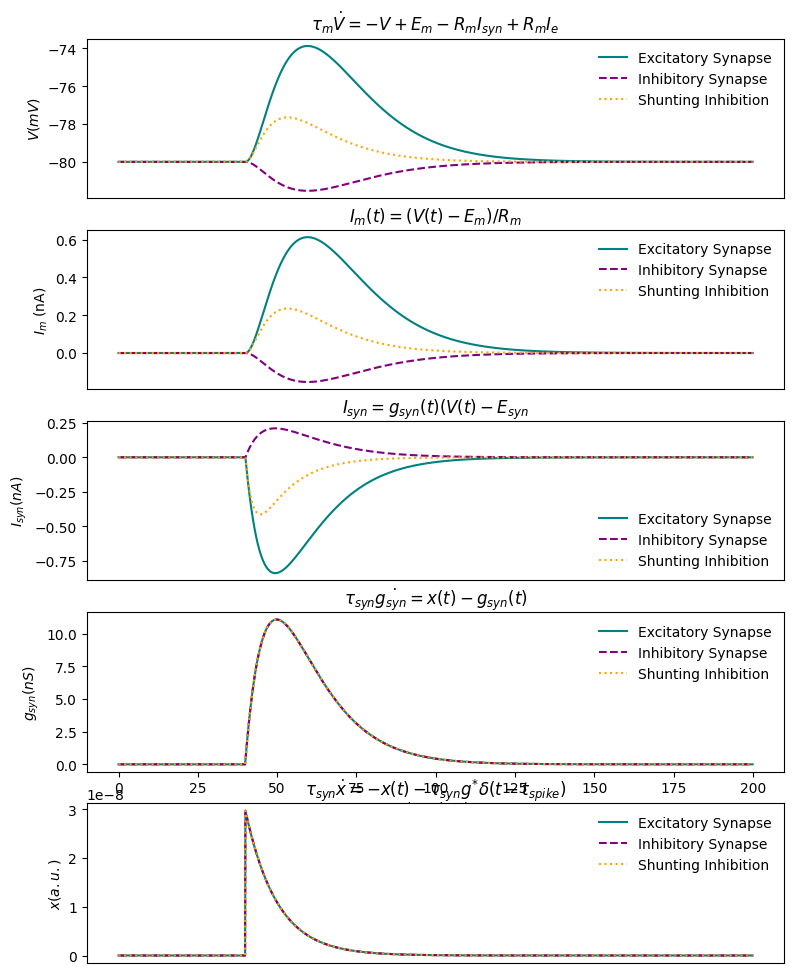

In [106]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(9, 12))


ax1.plot(sol[0]["ts"], sol[0]['V_t'], label="Excitatory Synapse")
ax1.plot(sol[1]["ts"], sol[1]['V_t'], linestyle="--", label="Inhibitory Synapse")
ax1.plot(sol[2]["ts"], sol[2]['V_t'], linestyle=":", label="Shunting Inhibition")

ax2.plot(sol[0]["ts"], sol[0]['I_m_t'], label="Excitatory Synapse")
ax2.plot(sol[1]["ts"], sol[1]['I_m_t'], linestyle="--", label="Inhibitory Synapse")
ax2.plot(sol[2]["ts"], sol[2]['I_m_t'], linestyle=":", label="Shunting Inhibition")

ax3.plot(sol[0]["ts"], sol[0]['I_syn_t'], label="Excitatory Synapse")
ax3.plot(sol[1]["ts"], sol[1]['I_syn_t'], linestyle="--", label="Inhibitory Synapse")
ax3.plot(sol[2]["ts"], sol[2]['I_syn_t'], linestyle=":", label="Shunting Inhibition")

ax4.plot(sol[0]["ts"], sol[0]['g_syn_t'], label="Excitatory Synapse")
ax4.plot(sol[1]["ts"], sol[1]['g_syn_t'], linestyle="--", label="Inhibitory Synapse")
ax4.plot(sol[2]["ts"], sol[2]['g_syn_t'], linestyle=":", label="Shunting Inhibition")

ax5.plot(sol[0]["ts"], sol[0]['x_t'], label="Excitatory Synapse")
ax5.plot(sol[1]["ts"], sol[1]['x_t'], linestyle="--", label="Inhibitory Synapse")
ax5.plot(sol[2]["ts"], sol[2]['x_t'], linestyle=":", label="Shunting Inhibition")

for ax, title, ylabel in zip(
    [ax1, ax2, ax3, ax4, ax5],
    [
        "$\\tau_{m}\\dot{V} = -V + E_{m} - R_{m}I_{syn} + R_{m}I_{e}$",
        "$I_m (t) = (V(t) - E_m) / R_m$",
        "$I_{syn} = g_{syn}(t)(V(t) - E_{syn}$",
        "$\\tau_{syn} \\dot{g_{syn}} = x(t) - g_{syn}(t)$",
        "$\\tau_{syn} \\dot{x} = -x(t) - \\tau_{syn}g^{*}\\delta(t-t_{spike})$"
    ],
    ["$V (mV)$", "$I_m$ (nA)", "$I_{syn} (nA)$", "$g_{syn} (nS)$", "$x (a.u.)$"]):

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.legend(frameon=False, loc='best')

    if ax != ax4:
        ax.set_xticks([])
    else:
        ax.set_xlabel("time (ms)")

plt.show()

# Explaining the differences

a.) The voltage deflection caused by the inhibtory synapse is much smaller than the one caused by the excitatory synapse due to the differences between the resting membrane potential and the respective reversal potentials (80 mV for the exc. synapse vs. 20 mV for the inh. synapse).

b.) Shunting inhibition introduces additional channels into the membrane, thereby increasing its effective leakiness and in turn decreases the input resistance and the membrane time constant. This leads to decreased integration of the synaptic input current and ultimately results in a smaller voltage defelction.

# 2. Integrate-and-fire neuron

# (a), (b) & (c)

In [110]:
pars_2_b = {
    'tau_syn': 10 * 10**-3,
    'tau_m'  : 10 * 10**-3,
    'R_m'    : 1  * 10**7,
    'g_star' : 30 * 10**-9,
    'E_m'    : -80 * 10**-3,
    'E_exc'  : 0 * 10**-3,
    'E_inh'  : -100 * 10**-3,
    'E_syn'  : 0 * 10**-3,
    'g_exc'  : 0 * 10**-9,
    'g_inh'  : 0 * 10**-9,
    'I_e'    : 3 * 10**-9,
    'thr'    : -54 * 10**-3   
}

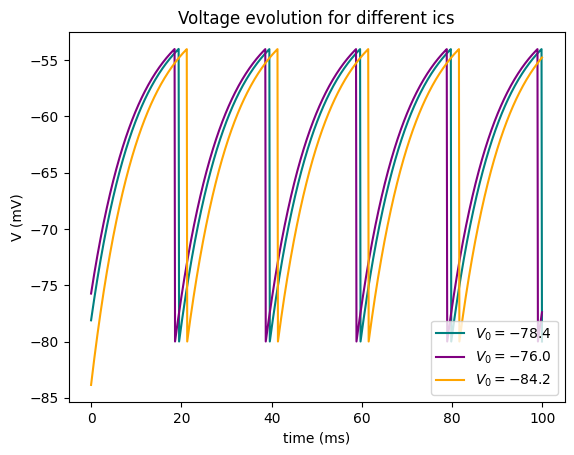

In [133]:
for k in range(3):
    initial_V = np.random.choice(np.arange(-85, -75, 0.1) * 10**-3)
    ics = (initial_V, 0, 0, 0)
    sol = euler_synaptic_if(tmax=0.1, dt=1e-4, pre_spike_times=[], pars=pars_2_b, ics=ics, reset=True)
    plt.plot(sol['ts'], sol['V_t'], label=f"$V_0 = {np.round(initial_V / 10**-3, 2)}$")
plt.legend()
plt.title('Voltage evolution for different ics')
plt.xlabel('time (ms)')
plt.ylabel('V (mV)')
plt.show()

# Interpretation

Initialising with different $V_0$'s introduces a phase delay in the firing of the different neurons. Since the firing thresholds are the same in all cases and the voltage evolves deterministically, this phase delay is persistent.

In [107]:
def get_fr_ISI(spiketimes):
    spiketimes *= 10**-3
    if len(spiketimes) > 1:
        mean_isi = np.mean([spiketimes[i+1] - spiketimes[i] for i in range(len(spiketimes) - 1)])
        fr = 1 / mean_isi
    else:
        fr = 0
    return fr

In [108]:
def get_fr_num(spiketimes, simtime):
    if len(spiketimes) > 1:
        fr = len(spiketimes) / simtime
    else:
        fr = 0
    return fr

In [109]:
def analytical_fr(pars):

    tau_syn = pars['tau_syn']
    tau_m   = pars['tau_m']
    R_m     = pars['R_m']
    g_star  = pars['g_star']
    E_m     = pars['E_m']
    E_exc   = pars['E_exc']
    E_inh   = pars['E_inh']
    E_syn   = pars['E_syn']
    g_exc   = pars['g_exc']
    g_inh   = pars['g_inh']
    I_e     = pars['I_e']
    thr     = pars['thr']
    V_reset = pars['E_m']
    
    fr = (tau_m * np.log( (R_m*I_e + E_m - V_reset) / (R_m*I_e + E_m - thr) )) ** -1

    return fr

In [119]:
input_stimuli = np.linspace(0, 5, 250) 

firing_rates_100_a = np.empty(len(input_stimuli))
firing_rates_500_a = np.empty(len(input_stimuli))

firing_rates_100_b = np.empty(len(input_stimuli))
firing_rates_500_b = np.empty(len(input_stimuli))

analytical_frs =  np.empty(len(input_stimuli))

for k, I_ext in enumerate(input_stimuli):

    initial_V = np.random.choice(np.arange(-85, -75, 0.1) * 10**-3)
    ics = (initial_V, 0, 0, 0)

    pars = update_pars(pars_2_b, ['I_e'], [I_ext * 10**-9])

    sol_1 = euler_synaptic_if(tmax=0.1, dt=1e-4, pre_spike_times=[], pars=pars, ics=ics, reset=True)
    firing_rates_100_a[k] = get_fr_ISI(sol_1['spiketimes'])
    firing_rates_100_b[k] = get_fr_num(sol_1['spiketimes'], np.max(sol_1['ts']) * 10**-3)

    sol_2 = euler_synaptic_if(tmax=0.5, dt=1e-4, pre_spike_times=[], pars=pars, ics=ics, reset=True)
    firing_rates_500_a[k] = get_fr_ISI(sol_2['spiketimes'])
    firing_rates_500_b[k] = get_fr_num(sol_2['spiketimes'], np.max(sol_2['ts']) * 10**-3)

    analytical_frs[k] = analytical_fr(pars)

/tmp/ipykernel_20119/1782649956.py:17: RuntimeWarning: divide by zero encountered in log
  fr = (tau_m * np.log( (R_m*I_e + E_m - V_reset) / (R_m*I_e + E_m - thr) )) ** -1
/tmp/ipykernel_20119/1782649956.py:17: RuntimeWarning: invalid value encountered in log
  fr = (tau_m * np.log( (R_m*I_e + E_m - V_reset) / (R_m*I_e + E_m - thr) )) ** -1


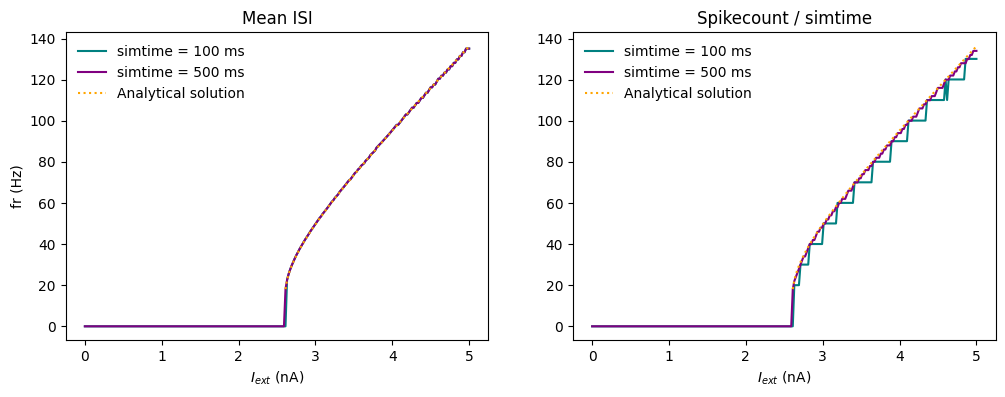

In [123]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(input_stimuli, firing_rates_100_a, label="simtime = 100 ms")
ax1.plot(input_stimuli, firing_rates_500_a, label="simtime = 500 ms")
ax1.plot(input_stimuli, analytical_frs, linestyle=":", label="Analytical solution")
ax1.set_title('Mean ISI')
ax1.set_ylabel('fr (Hz)')
ax1.set_xlabel('$I_{ext}$ (nA)')
ax1.legend(frameon=False)

ax2.plot(input_stimuli, firing_rates_100_b, label="simtime = 100 ms")
ax2.plot(input_stimuli, firing_rates_500_b, label="simtime = 500 ms")
ax2.plot(input_stimuli, analytical_frs, linestyle=":", label="Analytical solution")
ax2.set_title('Spikecount / simtime')
ax2.set_xlabel('$I_{ext}$ (nA)')
ax2.legend(frameon=False)

plt.show()

# Interpretation

### Mean ISI (w/o noise):
Using the (mean) ISI yields an estimate of the firing rate that seems to align quite well with the theoretical expression, even for very short simulations with only a few spikes. Since we are not adding a stochastic term to our ODE,the ISI is indeed the inverse of the firing rate. Hence, we can easily caculate the firing rate to numeric precision as soon as we measure on ISI.

### Spikecount / simtime:
This method yields an approximation of the firing rate that is highly dependent on the simulation time and gets better if we simulate longer. This is because the total number of spikes is a discrete measure where the simulation sometimes stops right before the next spike would be elicited. Hence, this approximation becomes better if we simulate longer, as the effects of this will become smaller.

### Real neurons
Real neurons should have a similar onset point, i.e. a value of the input current at which it starts spiking, but effects that casue a saturation of the firing rate might be more prominent in real neurons than in our simulations.

# 3. Synaptically coupled IF neurons

In [113]:
def euler_synaptic_coupling(tmax, dt, ics1, ics2, pars1, pars2, reset=False):
    
    tau_syn1 = pars1['tau_syn']
    tau_m1   = pars1['tau_m']
    R_m1     = pars1['R_m']
    g_star1 = pars1['g_star']
    E_m1     = pars1['E_m']
    E_syn1   = pars1['E_syn']
    I_e1     = pars1['I_e']
    thr1     = pars1['thr']

    V1, x1, g1, I_syn1 = ics1
    
    ts = np.arange(0, tmax, dt)

    Vs1 = np.array([])
    gs1 = np.array([])
    xs1 = np.array([])
    I_syns1 = np.array([])
    
    tau_syn2 = pars2['tau_syn']
    tau_m2   = pars2['tau_m']
    R_m2     = pars2['R_m']
    g_star2  = pars2['g_star']
    E_m2     = pars2['E_m']
    E_syn2   = pars2['E_syn']
    I_e2     = pars2['I_e']
    thr2     = pars2['thr']

    V2, x2, g2, I_syn2 = ics2

    Vs2 = np.array([])
    gs2 = np.array([])
    xs2 = np.array([])
    I_syns2 = np.array([])
    
    for t in ts:
        
        dV1dt = ( -V1 + E_m1 - R_m1*I_syn1 + R_m1*I_e1) / tau_m1
        dx1dt = -x1 / tau_syn1
        dg1dt = (x1 - g1) / tau_syn1
        I_syn1 = g1*(V1 - E_syn1) 
        
        V1 = V1 + dt*dV1dt
        x1 = x1 + dt*dx1dt
        g1 = g1 + dt*dg1dt

        dV2dt = ( -V2 + E_m2 - R_m2*I_syn2 + R_m2*I_e2) / tau_m2
        dx2dt = -x2 / tau_syn2
        dg2dt = (x2 - g2) / tau_syn2
        I_syn2 = g2*(V2 - E_syn2) 
        
        V2 = V2 + dt*dV2dt
        x2 = x2 + dt*dx2dt
        g2 = g2 + dt*dg2dt

        if reset == True and V1 >= thr1:
            V1 = E_m1
            x2 += g_star2

        if reset == True and V2 >= thr2:
            V2 = E_m2
            x1 += g_star1
        
        Vs1 = np.append(Vs1, V1)
        gs1 = np.append(gs1, g1)
        xs1 = np.append(xs1, x1)
        I_syns1 = np.append(I_syns1, I_syn1)

        Vs2 = np.append(Vs2, V2)
        gs2 = np.append(gs2, g2)
        xs2 = np.append(xs2, x2)
        I_syns2 = np.append(I_syns2, I_syn2)

    return {
        'ts' : ts / 10**-3, 

        'V_t1' : Vs1 / 10**-3, 
        'g_syn_t1' : gs1 / 10**-9, 
        'x_t1' : xs1, 
        'I_syn_t1' : I_syns1 / 10**-9,
        
        'V_t2' : Vs2 / 10**-3, 
        'g_syn_t2' : gs2 / 10**-9, 
        'x_t2' : xs2, 
        'I_syn_t2' : I_syns2 / 10**-9,
        }


In [114]:
pars_1 = {
    'E_m' : -70*10**-3,
    'R_m' : 1*10**7,
    'g_star' : 30*10**-9,
    'I_e' : 3.5*10**-9,
    'tau_syn' : 10*10**-3,
    'tau_m' : 10*10**-3,
    'thr' : -54*10**-3,
    'E_syn' : 0*10**-3,
}

pars_2 = pars_1.copy()

ics1 = [-60*10**-3, 0, 0, 0]
ics2 = [-70*10**-3, 0, 0, 0]

In [115]:
result = euler_synaptic_coupling(tmax=0.05, dt=1e-4, ics1=ics1, ics2=ics2, pars1=pars_1, pars2=pars_2, reset=True)

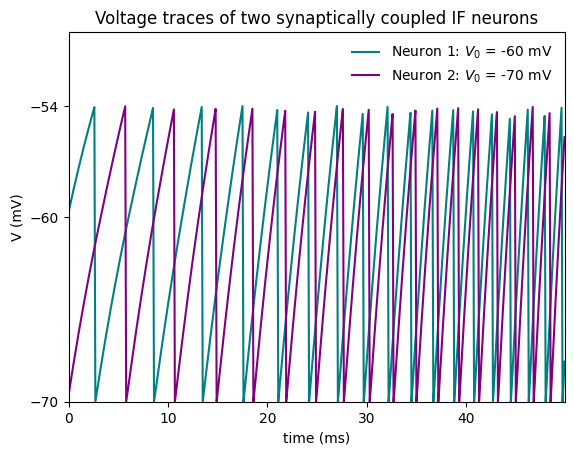

In [116]:
plt.plot(result['ts'], result['V_t1'], label="Neuron 1: $V_0$ = -60 mV")
plt.plot(result['ts'], result['V_t2'], label="Neuron 2: $V_0$ = -70 mV")
plt.legend(frameon=False)
plt.xlim(min(result['ts']), max(result['ts']))
plt.ylim([-70, -50])
plt.yticks([-70, -60, -54])
plt.ylabel('V (mV)')
plt.xlabel('time (ms)')
plt.title('Voltage traces of two synaptically coupled IF neurons')
plt.show()

# Interpretation

The firing of the two neurons seems to synchronize. This is because they are recurrently coupled which means that each spike will advance the firing of the other neuron until a steady state of synchronous firing is reached.

In [117]:
pars_I = update_pars(pars_1, ['I_e'], [3*10**-9])
pars_g = update_pars(pars_1, ['g_star'], [2 * 30*10**-9])
pars_tau = update_pars(pars_1, ['tau_syn'], [2 * 10*10**-3])

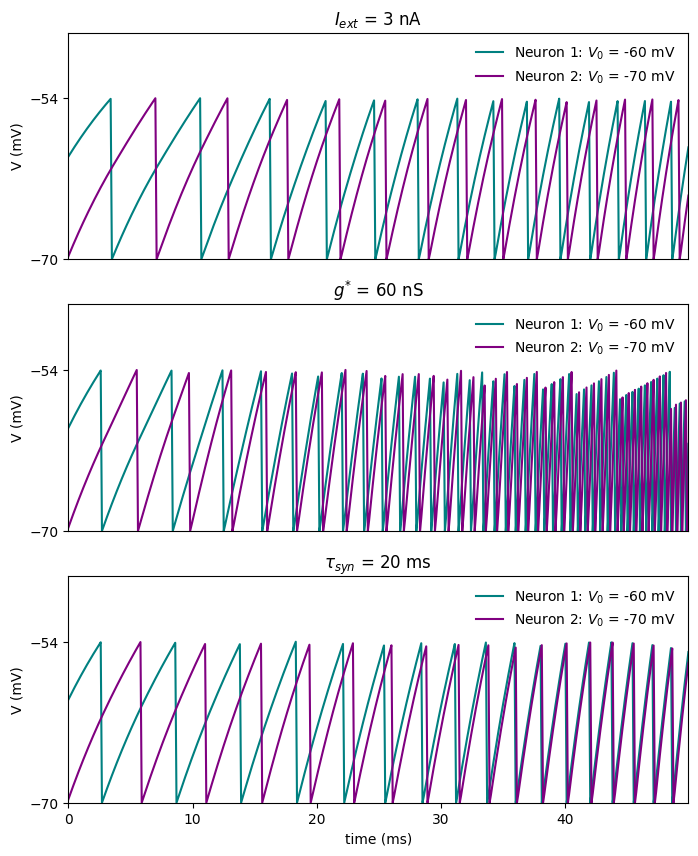

In [118]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))

for (pars, title, ax) in zip([pars_I, pars_g, pars_tau], ['$I_{ext}$ = 3 nA', '$g^{*}$ = 60 nS', '$\\tau_{syn}$ = 20 ms'], [ax1, ax2, ax3]):
    result = euler_synaptic_coupling(tmax=0.05, dt=1e-4, ics1=ics1, ics2=ics2, pars1=pars, pars2=pars, reset=True)
    ax.plot(result['ts'], result['V_t1'], label="Neuron 1: $V_0$ = -60 mV")
    ax.plot(result['ts'], result['V_t2'], label="Neuron 2: $V_0$ = -70 mV")
    ax.legend(frameon=False)
    ax.set_xlim(min(result['ts']), max(result['ts']))
    ax.set_yticks([-70, -54])
    ax.set_ylim([-70, -47.5])
    ax.set_ylabel('V (mV)')
    ax.set_title(title)
    if ax != ax3:
        ax.set_xticks([])
ax3.set_xlabel('time (ms)')

plt.show()

# Interpretation

### $I_{ext}$
A smaller value of $I_{ext}$ reduces the firing rate. As a result, the neurons start to synchronize much slower.

### $g^*$

A higher value of $g^*$ increases the EPSPS of the neurons and therefore leads to faster synchronization. During the end of the simulation, other effects of this increased synaptic coupling become apparent: The neurons seem to reset before really reaching the firing threshold. Presumably, this is due to our implementation of the reset mechanism, where the membrane voltage is reset once it surpasses the threshold value for the next simulation time step. Since both neurons are super close to the threshold at the same time and strongly coupled, this might cause an "early reset".

### $\tau_{syn}$

A bigger synaptic time constant leads to better integration of synaptic inputs and thereby promotes synchronization of the two recurrently coupled neurons. 